## Домашка 4

#### *«Вы видите, но не наблюдаете.» — Шерлок*

Эта домашка про мониторинг метрик и детекцию аномалий. За неё можно получить максимум 12 баллов. На решение отводится **14 календарных дней** с момента выдачи. Обратите внимание, что **дедлайны на курсе сразу жёсткие**, а значит отправка решений после них запрещена.
Задание выполняется самостоятельно, списывания не допускаются. При обнаружении одинаковых работ балл за задание анулируется у всех студентов, вне зависимости от того, кто у кого списал.

#### **Как сдать домашку?**
1. Создайте закрытый репозиторий в личном гитхаб аккаунте для нашего предмета.
2. Пригласите в него своего ассистента — распределение по ассистентам и их гитхаб юзернеймы находятся в [ведомости](https://docs.google.com/spreadsheets/d/13lHNf6xU6tZhqzVMAb8sV3RgyyDatepwo7FJ6FhZ0vY/edit?usp=sharing) на листочке нашей дисциплины. Это можно сделать в настройках через раздел Collaborators and teams, уровень доступа ассистента должен быть Write.
3. Скачайте этот ноутбук и решите задания (локально или в Google Colab).
4. В репозитории предмета создайте ветку с номером ДЗ (например hw_4). В эту ветку запушьте .ipynb-файл с решением. Создайте pull request и добавьте в него ассистента как Reviewer. В этот же PR можете пушить сколько угодно изменений, будем смотреть на последнюю версию до наступления дедлайна.
5. В процессе решения вы будете получать ответы на список вопросов, собранный в Яндекс-Формах. Впишите в него ответы.
6. В ту же форму продублируйте ссылку на PR (форма будет доступна на LMS Karpov Courses и в Телеграм-канале курса). Вопросы в Формах с автопроверкой, однако сданный тест, к которому не была приложена ссылка на ноутбук с расчетом ответов, получает 0 баллов.

Пункты 1-2 проделываются один раз. Если вы прошли эти шаги при сдаче других домашек, повторять их не нужно, начинайте сразу с пункта 3.

**Внимание**: Если вы работаете в Google Colab, также скачивайте .ipynb файл и публикуйте его в репозитории. Ссылки на Colab к сдаче не принимаются.


Все датасеты, с которыми предлагается работать в домашних заданиях, взяты из открытых источников или сгенерированы. Любые паттерны, найденные вне заданной канвы решения, являются случайными и не несут в себе смысла или инсайта.

[Данные](https://github.com/brezhnevaan/hse_product_metrics_course/releases/download/datasets_for_hw/hw_4_data.zip)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.tsa.seasonal import STL
import math

### Warm up

#### 1. Сопоставьте метод детекции аномалий с контекстом применения — 2 балла

a) Онлайн-мониторинг   
b) Батч-анализ по историческим данным  

1. Правило 3σ.
2. Generalized ESD
3. Grubbs test
4. CUMSUM
5. EWMA
6. STL-разложение + Generalized ESD

In [ ]:
# your answer is here

| Контекст применения | Методы детекции аномалий |
|----------------------|---------------------------|
| **a) Онлайн-мониторинг** | Правило 3σ, CUMSUM, EWMA |
| **b) Батч-анализ по историческим данным** | Grubbs test, Generalized ESD, STL-разложение + Generalized ESD |


### Case Study. Система мониторинга метрик для Ecom-приложения 🥪

**Легенда**  
Вы работаете продуктовым аналитиком в ecom-приложении доставки FMCG-товаров. Компания — развивающийся стартап, в котором еще не выстроена система мониторинга метрик.   

Вам поручили провести исследование подходов к детекции аномалий на исторических данных и выбрать методологии, которые будет применять ваша компания для онлайн-мониторинга и ретроспективного анализа.

In [ ]:
df = pd.read_csv('/content/hw_4_fmcg.csv')

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head()

,date,items_sold,gmv,avg_item_price
0,2023-01-01,2907,14944.41,5.140836
1,2023-01-02,3030,16065.13,5.302023
2,2023-01-03,3070,17170.30,5.592932
3,2023-01-04,2708,14367.19,5.305462
4,2023-01-05,3177,16918.53,5.325316


Описание данных:

- date — дата, на которую агрегированы данные
- items_sold — число проданных в день товаров
- gmv – GMV проданных в день товаров
- avg_item_price — средняя цена проданных в день товаров

#### 2. Правило 3σ — 2 балла

1) Реализуйте правило 3σ для каждой метрики:
- gmv;
- items_sold;
- avg_item_price.

Расчет производите на всем датасете. В этом пункте вы имитируете онлайн-мониторинг, поэтому проверка проводится для каждой даты, а границы контроля рассчитываются за последние 28 дней до самой даты.

2) Постройте графики: метрика + границы контроля + выделенные аномалии.

*Советую обернуть правило для расчета 3σ в функцию, она пригодится на следующем шаге.*

**Внимание: Тут и в дальнейшем для визуализации и ответа на тестовые вопросы формы используйте только данные ЗА МАЙ.**

In [ ]:
#  Визуализация
def get_3sigma_vis(df, x, metric, control=True):
    plt.figure(figsize=(12,6))

    # линия метрики + маркеры
    plt.plot(df[x], df[metric], marker='o', label=metric)

    # линии контрольных границ
    if control:
        plt.plot(df[x], df[f'{metric}_ucl'], label=f'{metric}_ucl')
        plt.plot(df[x], df[f'{metric}_lcl'], label=f'{metric}_lcl')

    # выделим аномалии красными точками
    plt.scatter(
        df[df[f'is_anomaly_{metric}']][x],
        df[df[f'is_anomaly_{metric}']][metric],
        color='red', s=60, zorder=3, label='anomaly'
    )

    # подпишем значения
    for xi, yi in zip(df[x], df[metric]):
        plt.text(xi, yi + 0.005, f'{yi:.2f}', fontsize=8, ha='center', va='bottom')

    plt.title(f'{metric.capitalize()} Dynamics')
    plt.xlabel(x)

    plt.xticks(ticks=df[x], labels=df[x].astype(str), rotation=45)
    plt.ylabel(metric)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Контрольные границы 3σ (скользящее окно за предыдущие дни)
def get_3_sigma_cl(df, metric, window=28, sigma=3):
    # считаем среднее и sd на последних окнах значениях ДО текущей даты
    df[f'{metric}_mean'] = df[metric].shift(1).rolling(window=window, min_periods=window).mean()
    df[f'{metric}_ssd']  = df[metric].shift(1).rolling(window=window, min_periods=window).std(ddof=1)

    # верхняя/нижняя границы
    df[f'{metric}_ucl'] = df[f'{metric}_mean'] + sigma * df[f'{metric}_ssd']
    df[f'{metric}_lcl'] = df[f'{metric}_mean'] - sigma * df[f'{metric}_ssd']

    # флаг аномалии
    df[f'is_anomaly_{metric}'] = (df[metric] < df[f'{metric}_lcl']) | (df[metric] > df[f'{metric}_ucl'])

    return df

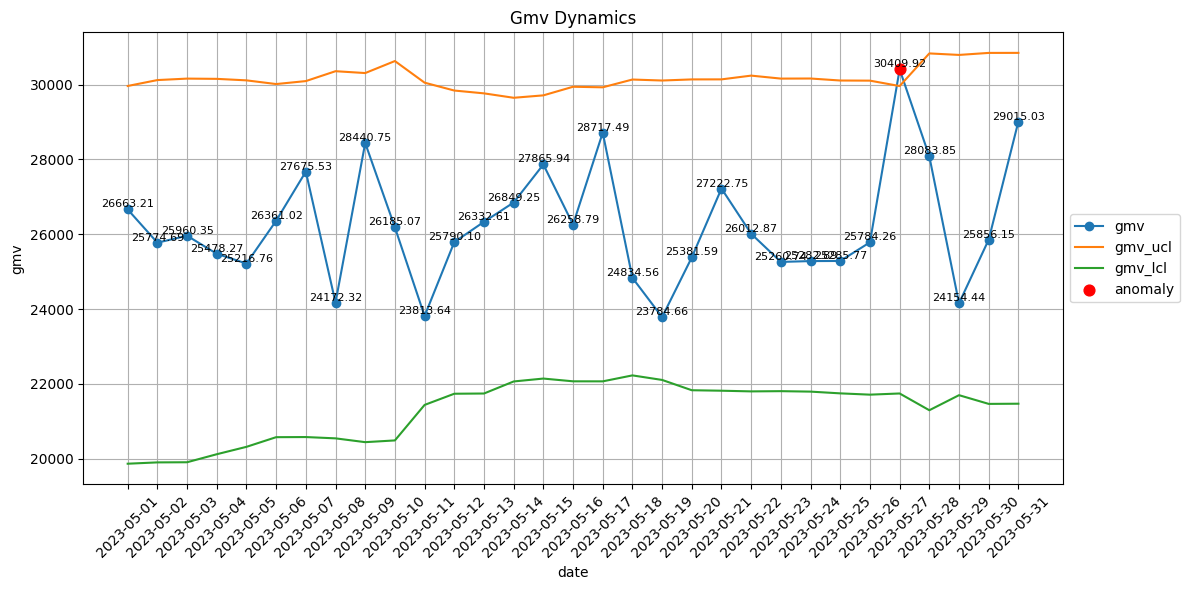

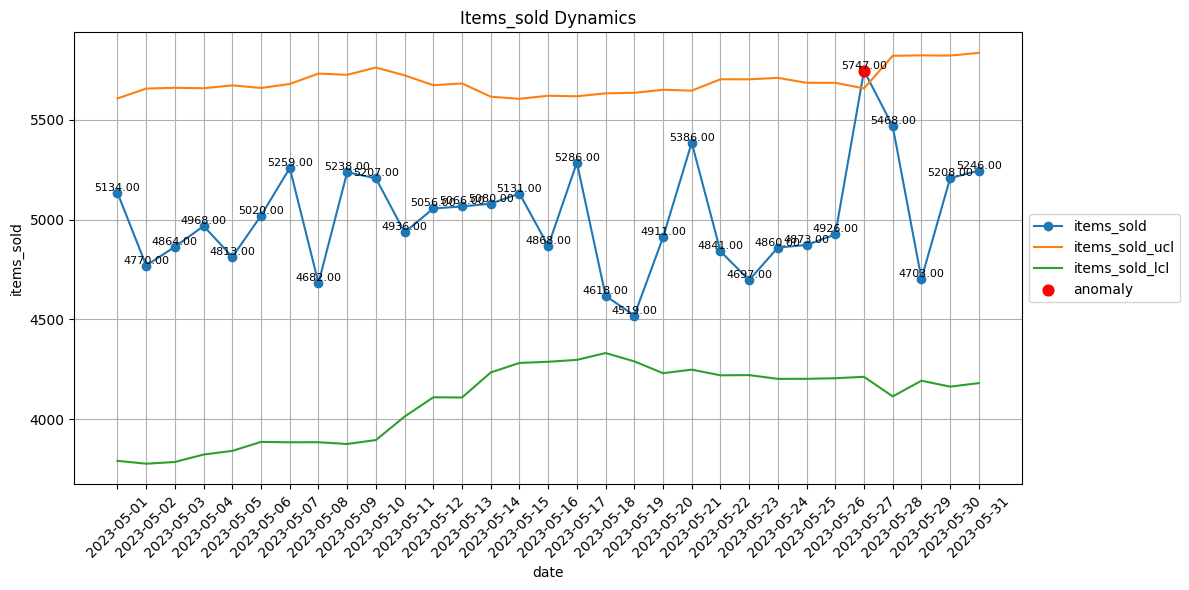

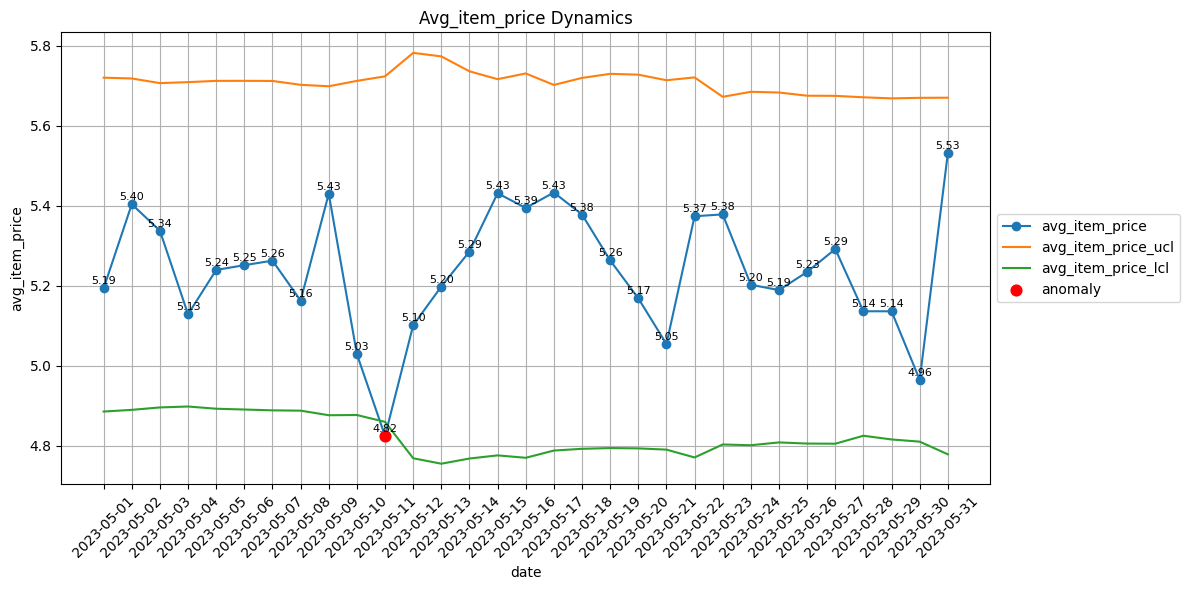

In [ ]:
# Применим правило 3σ для всех трёх метрик
metrics = ['gmv', 'items_sold', 'avg_item_price']
for m in metrics:
    df = get_3_sigma_cl(df, m, window=28, sigma=3)

# Фильтр для МАЯ
df_may = df[(df['date'] >= pd.Timestamp(2023,5,1)) & (df['date'] < pd.Timestamp(2023,6,1))].copy()

# Построим графики по каждой метрике
for m in metrics:
    get_3sigma_vis(df_may, 'date', m)

In [ ]:
# подсчёт количества аномалий в мае
anomaly_summary = {
    m: int(df_may[f'is_anomaly_{m}'].sum())
    for m in metrics
}
print('Количество аномалий в мае:', anomaly_summary)

Количество аномалий в мае: {'gmv': 1, 'items_sold': 1, 'avg_item_price': 1}


**Задание**: введите число, являющееся аномальным значением метрики items_sold.

In [ ]:
df_may.loc[df_may['is_anomaly_items_sold'], ['date', 'items_sold']]


,date,items_sold
146,2023-05-27,5747


#### 3. Дельта-ряды — 2 балла

1) Рассчитайте дельты значений текущего дня с предыдущим для каждой метрики, затем примените к полученным дельтам правило 3σ:
- gmv;
- items_sold;
- avg_item_price.

Расчет производите на всем датасете. В этом пункте вы имитируете онлайн-мониторинг, поэтому проверка проводится для каждой даты, а границы контроля рассчитываются за последние 28 дней до самой даты.

2) Постройте графики: дельты метрики + границы контроля + выделенные аномалии.

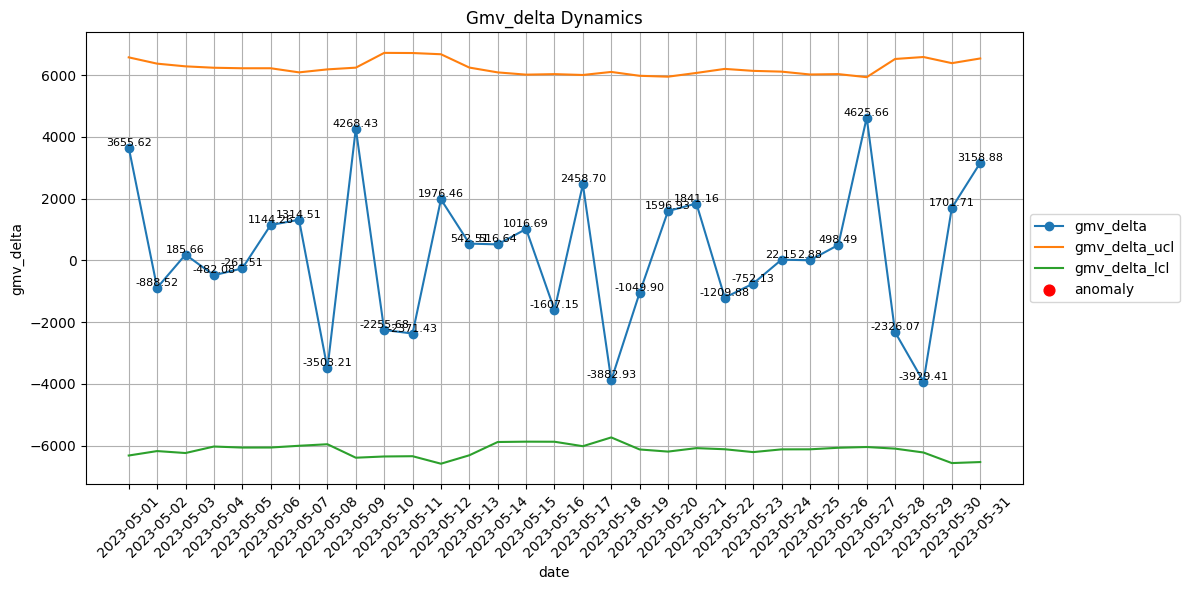

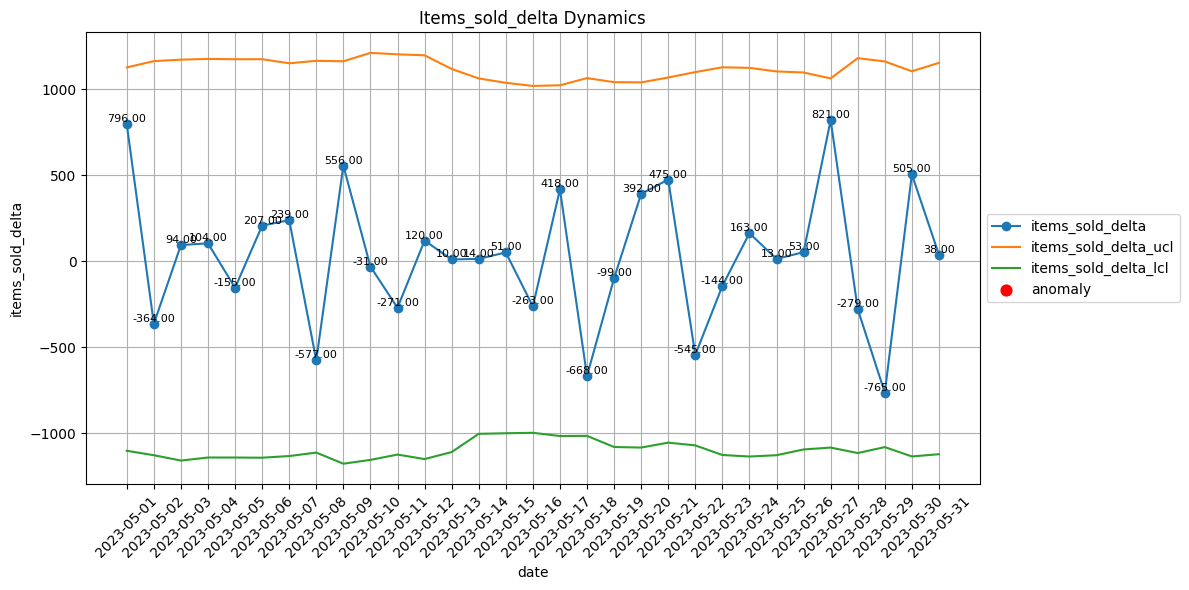

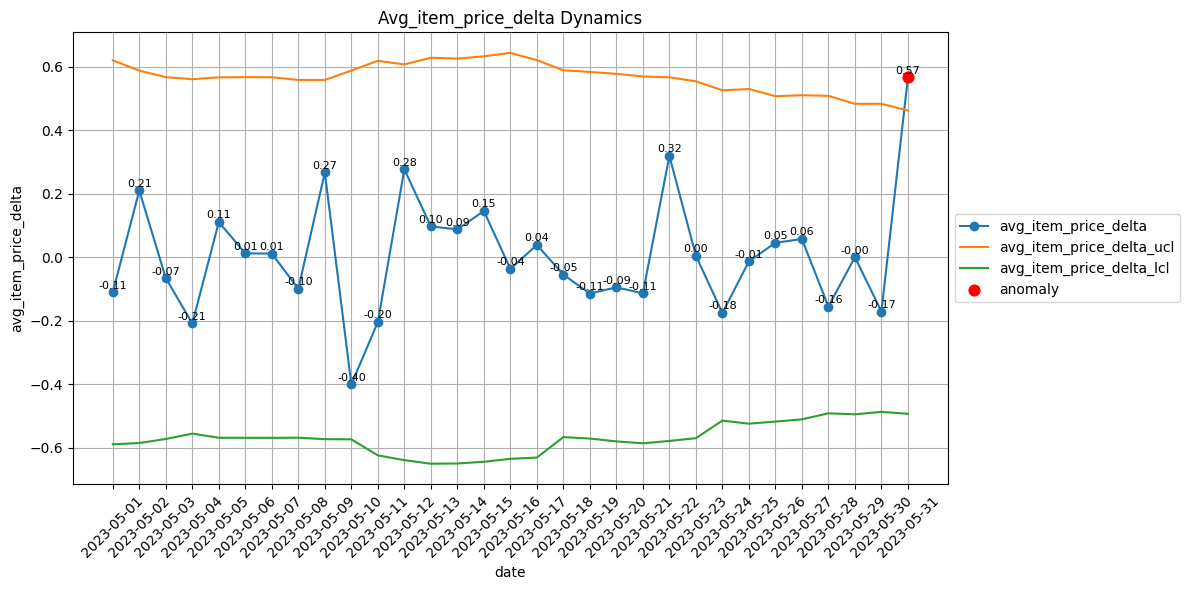

,date,items_sold_delta


In [ ]:
# Считаем дельты — разницу с предыдущим днём
for m in metrics:
    df[f'{m}_delta'] = df[m] - df[m].shift(1)

# Применим правило 3σ к дельтам (окно 28 дней)
for m in metrics:
    df = get_3_sigma_cl(df, f'{m}_delta', window=28, sigma=3)

# Фильтрируем данные за май
df_may = df[(df['date'] >= '2023-05-01') & (df['date'] < '2023-06-01')]

#  Строим графики дельт (дельта + границы + аномалии)
for m in metrics:
    get_3sigma_vis(df_may, 'date', f'{m}_delta')

#  Посмотрим, где есть аномальные дельты по items_sold
df_may.loc[df_may['is_anomaly_items_sold_delta'], ['date', 'items_sold_delta']]


In [ ]:
# your code is here

**Задание**: введите аномальное значение дельты avg_item_price, значение округлите до сотых.

In [ ]:
anomalies_price = df_may.loc[df_may['is_anomaly_avg_item_price_delta'], ['date', 'avg_item_price_delta']]
anomalies_price['avg_item_price_delta'] = anomalies_price['avg_item_price_delta'].round(2)

display(anomalies_price)

,date,avg_item_price_delta
150,2023-05-31,0.57


#### 4. Generalized ESD — 2 балла

1) Реализуйте [Generalized ESD](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h3.htm). Обратите внимание, с какими данными работает метод — онлайн или батч? Учтите это в реализации.
2) Найдите аномалии для дельт каждой метрики ЗА МАЙ (используйте данные, полученные на прошлом шаге):
- gmv;
- items_sold;
- avg_item_price.
3) Сравните результаты с правилом 3σ на дельтах: разошлись ли методы?

*Советую обернуть Generalized ESD в функцию, она пригодится на следующем шаге.*

In [ ]:
def get_esd(df, metric, alpha=0.05):
    """
    Реализует Generalized ESD test
    Возвращает DataFrame с флагом is_anomaly_<metric>
    """
    df = df.copy()
    x = df[metric].dropna().values
    n = len(x)
    max_outliers = n // 2 - 1

    outlier_indices = []

    for i in range(1, max_outliers + 1):
        mean_x = np.mean(x)
        std_x = np.std(x, ddof=1)
        if std_x == 0:
            break

        # находим индекс точки с максимальным отклонением
        R = np.abs(x - mean_x) / std_x
        R_i = R.max()
        max_idx = R.argmax()

        # критическое значение λ_i
        p = 1 - alpha / (2 * (n - i + 1))
        t_crit = t.ppf(p, n - i - 1)
        lam_i = ((n - i) * t_crit) / np.sqrt((n - i - 1 + t_crit**2) * (n - i + 1))

        # проверяем порог
        if R_i > lam_i:
            outlier_indices.append(max_idx)
            x = np.delete(x, max_idx)
        else:
            break

    df[f'is_anomaly_{metric}'] = False
    if outlier_indices:
        df.iloc[outlier_indices, df.columns.get_loc(f'is_anomaly_{metric}')] = True

    return df


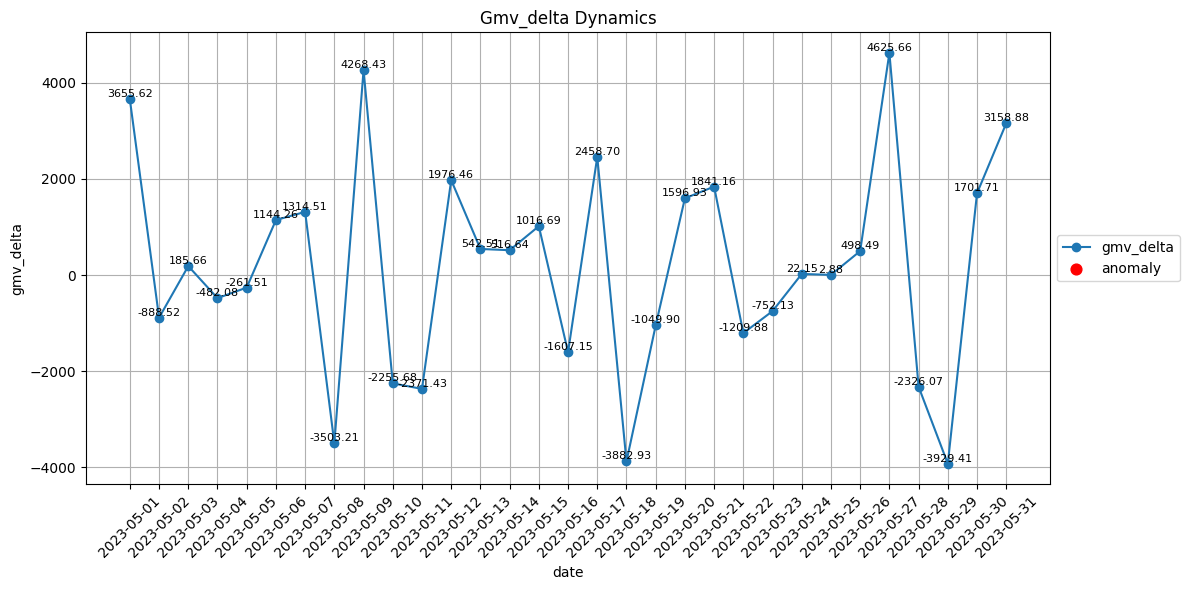

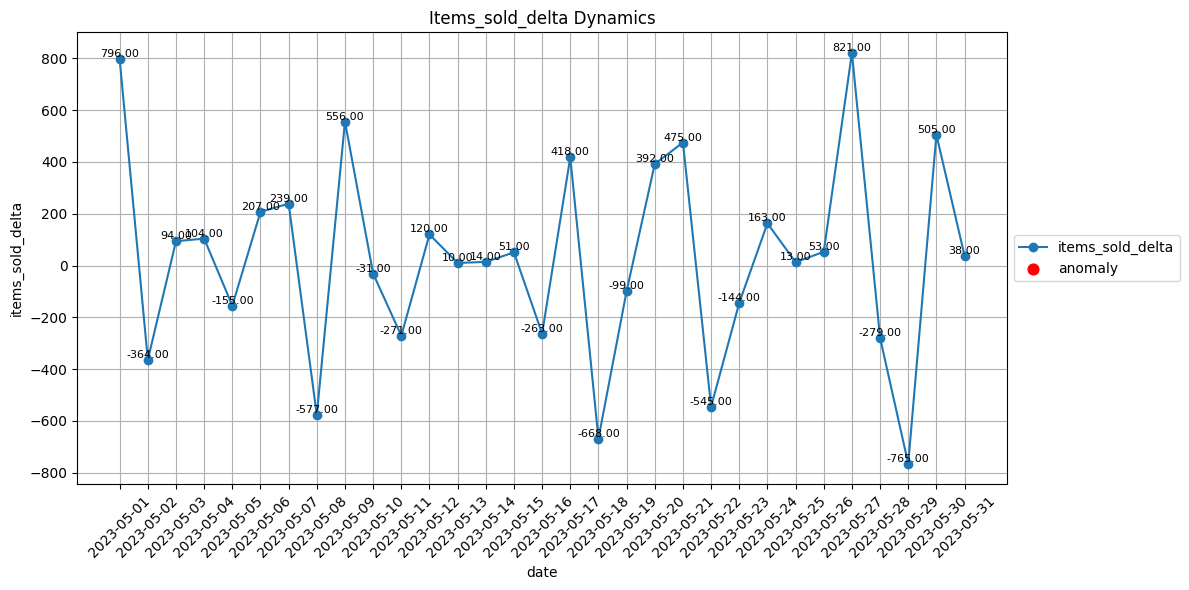

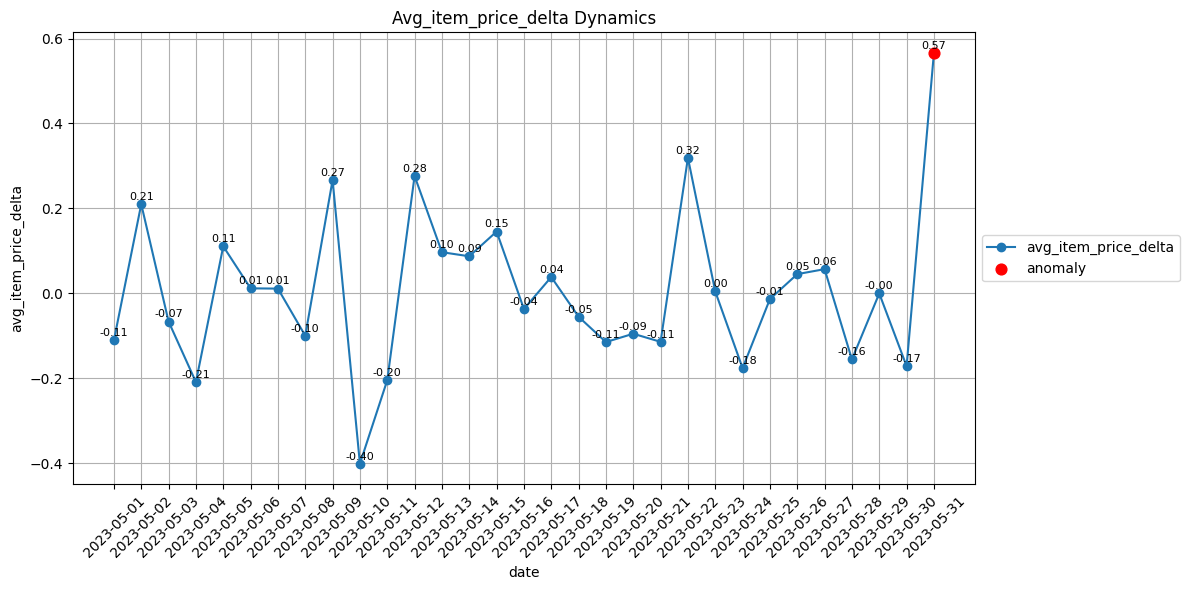

In [ ]:
# Применяем ESD для дельт за май
df_may = df[(df['date'] >= '2023-05-01') & (df['date'] < '2023-06-01')].copy()

for m in metrics:
    df_may = get_esd(df_may, f'{m}_delta', alpha=0.05)

# Визуализируем
for m in metrics:
    get_3sigma_vis(df_may, 'date', f'{m}_delta', control=False)


In [ ]:
# посмотрим, где обнаружены аномалии по avg_item_price_delta
df_may.loc[df_may['is_anomaly_avg_item_price_delta'], ['date', 'avg_item_price_delta']]


,date,avg_item_price_delta
150,2023-05-31,0.566188


**Задание**: для какой даты дельта avg_item_price является аномалией по методу Generalized ESD? Введите дату в фоммате YYYY-MM-DD

In [ ]:
esd_anomaly_date = df_may.loc[df_may['is_anomaly_avg_item_price_delta'], 'date'].dt.strftime('%Y-%m-%d').tolist()
print( esd_anomaly_date)


['2023-05-31']


Методы не разошлись — правило 3σ и Generalized ESD обнаружили одну и ту же аномалию 31 мая.

#### 5. STL-разложение — 2 балла

1) Для каждой метрики выполните STL-разложение с недельной сезонностью (7 дней) на данных всего датасета:
- gmv;
- items_sold;
- avg_item_price.

Используйте STL из библиотеки statsmodels (уже есть в импортах).
  
2) Для каждой метрики визуализируйте компоненты: тренд, сезонность, остатки (на всем датасете).

4) На остатках примените Generalized ESD, можете использовать функцию из прошлого шага. Это упражнение проделываем только на данных ЗА МАЙ.

5) Подумайте, для каждой ли метрики имеет смысл использовать STL, везде ли визуально присутствуют тренд и недельная сезонность?

In [ ]:
# Визуализация компонентов STL
def get_stl_viz(stl_result, metric):
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    resid = stl_result.resid
    observed = stl_result.observed

    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(observed, label='Observed')
    axes[0].legend(loc='upper left')

    axes[1].plot(trend, color='orange', label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(seasonal, color='green', label='Seasonal')
    axes[2].legend(loc='upper left')

    axes[3].plot(resid, color='red', label='Residuals')
    axes[3].legend(loc='upper left')

    fig.suptitle(f'{metric} STL', fontsize=14)
    plt.tight_layout()
    plt.show()


# Расчёт STL для метрики
def get_stl_results(df, x, metric, period=7):
    # приведём к индексу по дате и запустим STL
    ts = df.sort_values(x).set_index(x)[metric]
    stl = STL(ts, period=period)
    stl_result = stl.fit()
    return stl_result


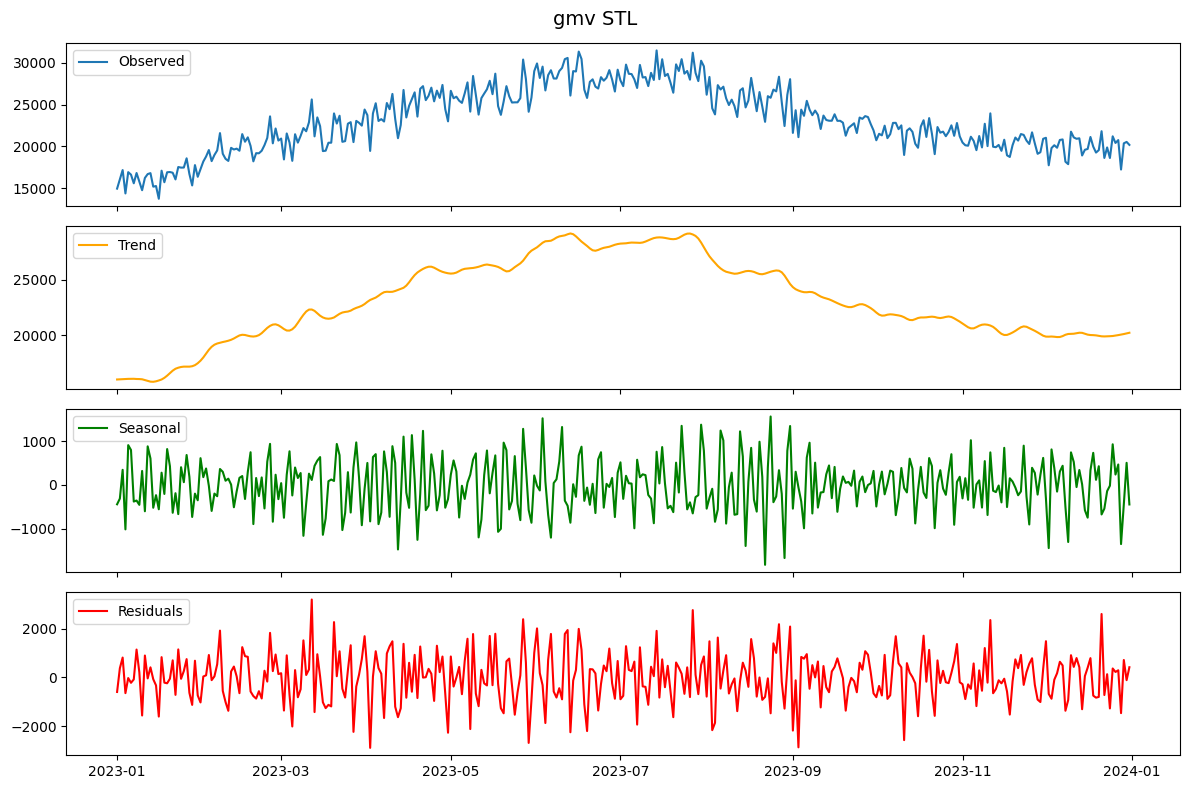

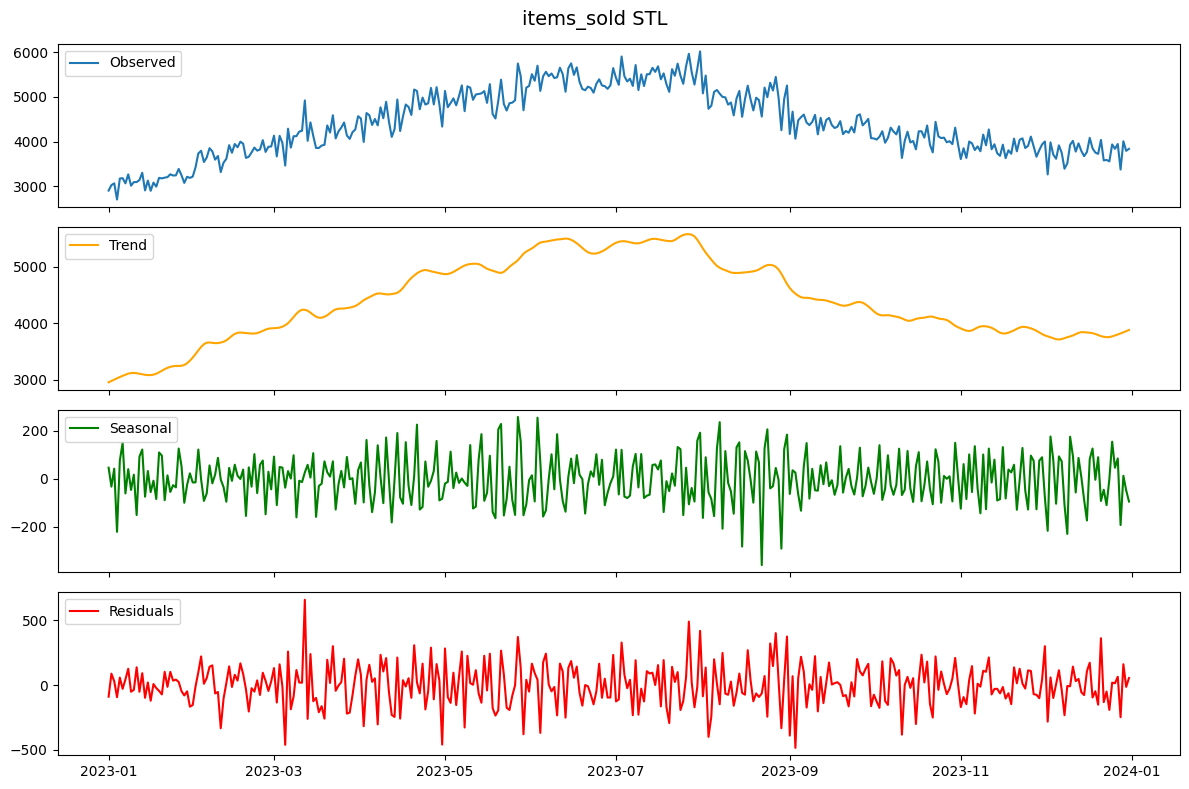

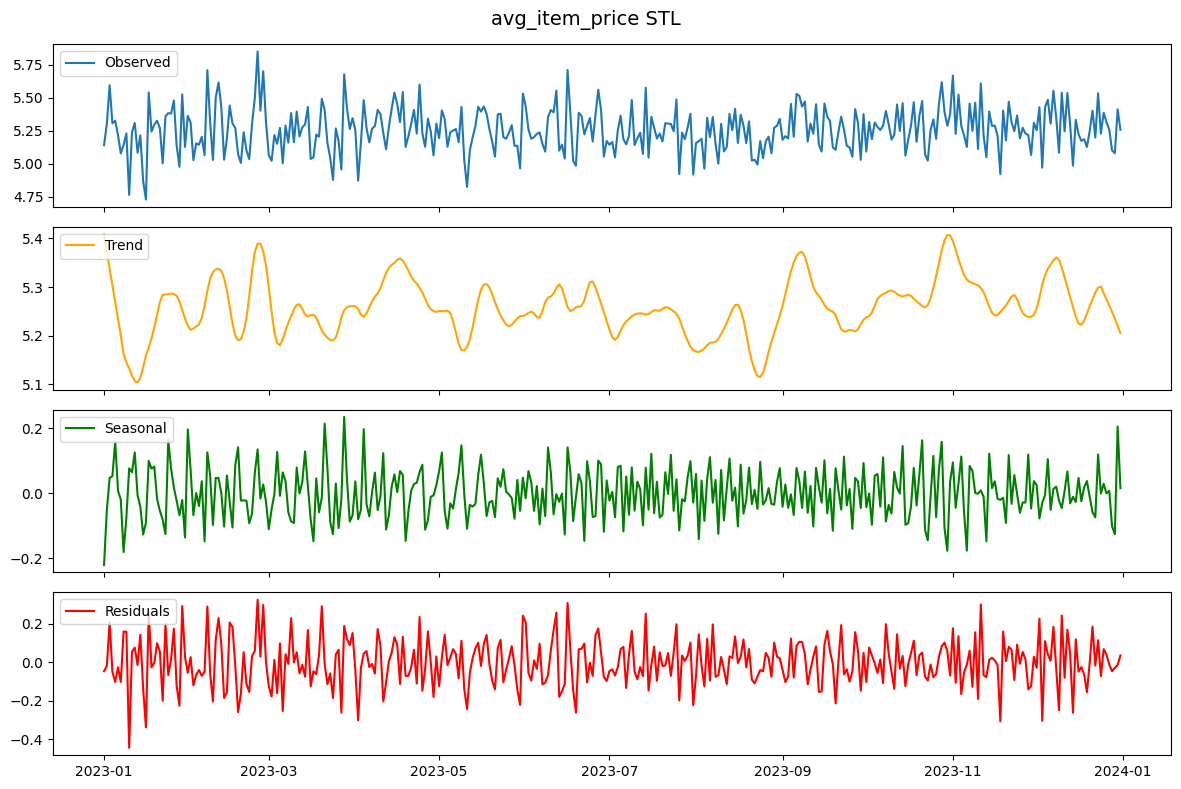

In [ ]:
# Выполним STL для всех трёх метрик на всём датасете
metrics = ['gmv', 'items_sold', 'avg_item_price']

df = df.sort_values('date').reset_index(drop=True)

stl_results = {}

for m in metrics:
    # считаем STL и сохраняем результат
    stl_m = get_stl_results(df, 'date', m, period=7)
    stl_results[m] = stl_m

    # визуализация
    get_stl_viz(stl_m, m)

    # сохраним компоненты в датафрейм
    df[f'{m}_trend'] = stl_m.trend.values
    df[f'{m}_seasonal'] = stl_m.seasonal.values
    df[f'{m}_resid'] = stl_m.resid.values

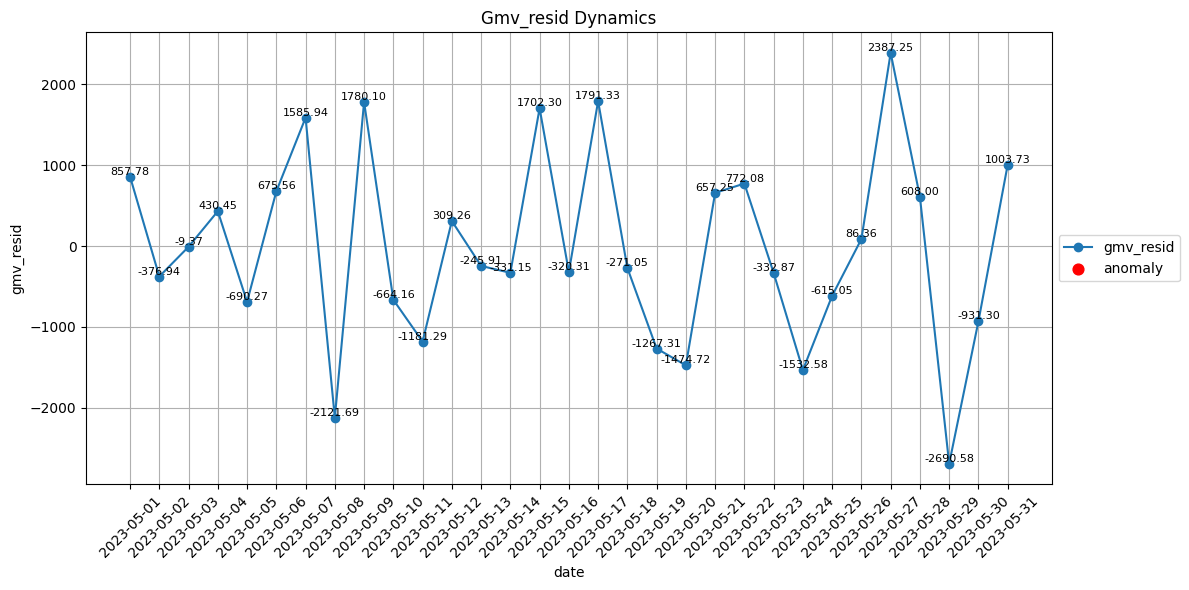

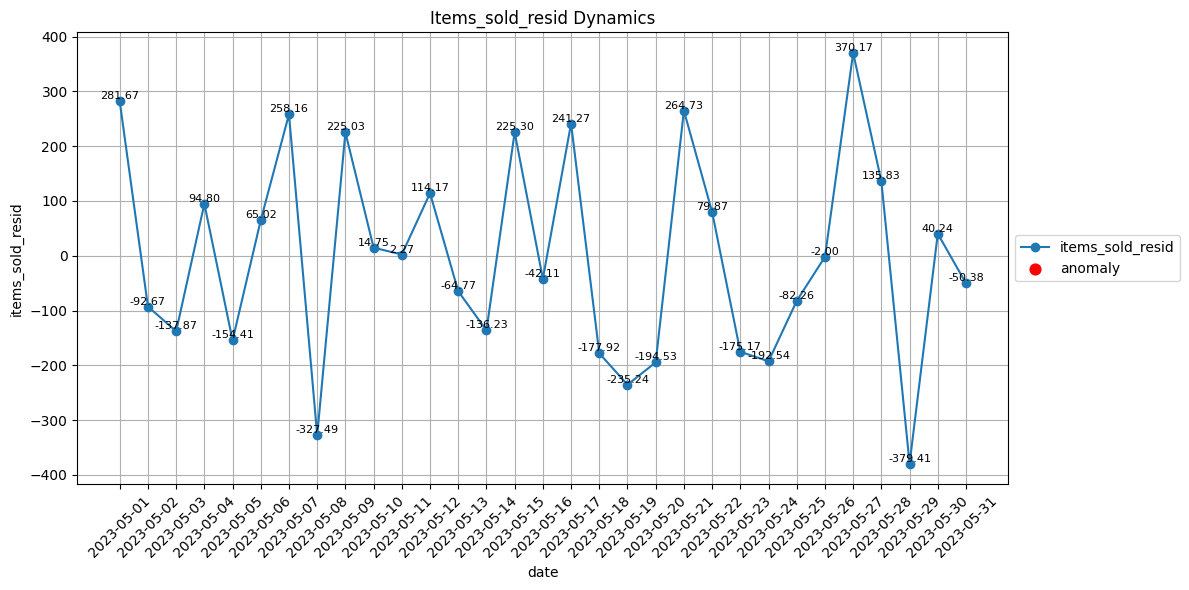

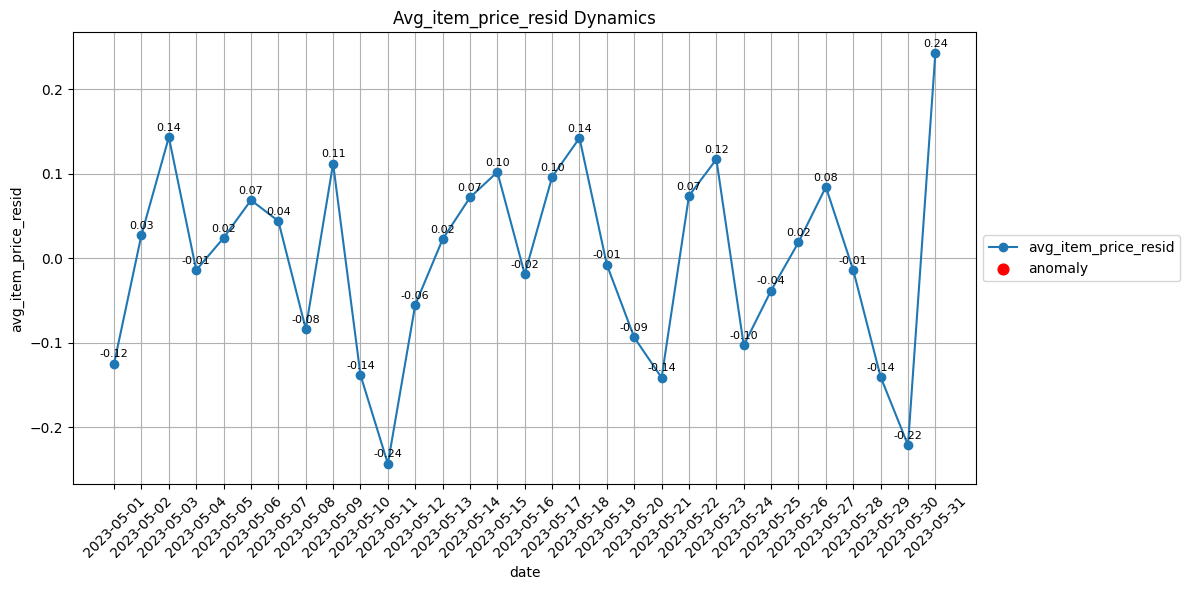

In [ ]:
# ESD на остатках: только МАЙ (батч-анализ)

# фильтр за май
df_may = df[(df['date'] >= pd.Timestamp(2023, 5, 1)) & (df['date'] < pd.Timestamp(2023, 6, 1))].copy().reset_index(drop=True)

# применим Generalized ESD к остаткам каждой метрики
for m in metrics:
    resid_col = f'{m}_resid'
    df_may = get_esd(df_may, resid_col, alpha=0.05)

# визуализация
for m in metrics:
    resid_col = f'{m}_resid'
    get_3sigma_vis(df_may, 'date', resid_col, control=False)


In [ ]:
# посмотрим итоговые аномалии по остаткам за май
for m in metrics:
    resid_col = f'{m}_resid'
    flag_col = f'is_anomaly_{resid_col}'
    out = df_may.loc[df_may[flag_col], ['date', resid_col]]
    print(f'Аномалии на остатках {m} за май:')
    print(out.to_string(index=False) if not out.empty else 'нет')

Аномалии на остатках gmv за май:
нет
Аномалии на остатках items_sold за май:
нет
Аномалии на остатках avg_item_price за май:
нет


**Задание**: введите количество аномалий (сумма для всех метрик — целое число), полученное на остатках STL разложением и Generalized ESD.

In [ ]:
anomaly_total = sum(
    df_may[f'is_anomaly_{m}_resid'].sum()
    for m in ['gmv', 'items_sold', 'avg_item_price']
)

print(int(anomaly_total))

0


STL-разложение имеет смысл не для всех метрик.
Для gmv и items_sold тренд и недельная сезонность выражены отчётливо — продажи и выручка демонстрируют закономерные колебания и общий рост или спад во времени, поэтому применение STL позволяет отделить эти компоненты и корректно искать аномалии в остатках.
А вот для avg_item_price тренд и сезонность визуально выражены слабо: средняя цена товаров колеблется случайно, без устойчивого недельного паттерна, поэтому STL-разложение для этой метрики малоинформативно — лучше использовать методы без выделения сезонности (например, правило 3σ или EWMA).

#### 6. EWMA — 2 балла

1) Реализуйте метод [EWMA](https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc324.htm) для каждой метрики:
- gmv;
- items_sold;
- avg_item_price.

При расчётах используйте экспоненциальное сглаживание λ = 0.2, доверительные границы μ ± L·σ, где L = 3. Стандартное отклонение вычисляйте на окне 28 дней и используйте функцию асимптотического приближения:

$$
\sigma_z(\infty) = \sigma \sqrt{\frac{\lambda}{2-\lambda}}
$$

Обратите внимание, что в pandas есть [встроенная функция экспоненциального сглаживания](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html).


2) Постройте графики: сглаженная метрика + границы контроля + выделенные аномалии.
3) Напишите, какой из подходов вам больше всего понравился для онлайн-мониторинга, а какой — для ретроспективного анализа, и почему. Тут нет правильного ответа :)

In [ ]:
def get_ewma_control(df, metric, lambda_=0.2, L=3, window=28):
    # посчитаем EWMA, σ и контрольные границы
    df = df.copy()
    # экспоненциальное сглаживание
    df[f'{metric}_ewma'] = df[metric].ewm(alpha=lambda_, adjust=False).mean()

    # стандартное отклонение на окне 28 дней (обычное скользящее)
    df[f'{metric}_std'] = df[metric].rolling(window=window, min_periods=window).std(ddof=1)

    # асимптотическое приближение σ_z(∞)
    df[f'{metric}_sigma_z'] = df[f'{metric}_std'] * math.sqrt(lambda_ / (2 - lambda_))

    # контрольные границы
    df[f'{metric}_ucl'] = df[f'{metric}_ewma'] + L * df[f'{metric}_sigma_z']
    df[f'{metric}_lcl'] = df[f'{metric}_ewma'] - L * df[f'{metric}_sigma_z']

    # флаг аномалии
    df[f'is_anomaly_{metric}'] = (df[metric] > df[f'{metric}_ucl']) | (df[metric] < df[f'{metric}_lcl'])

    return df


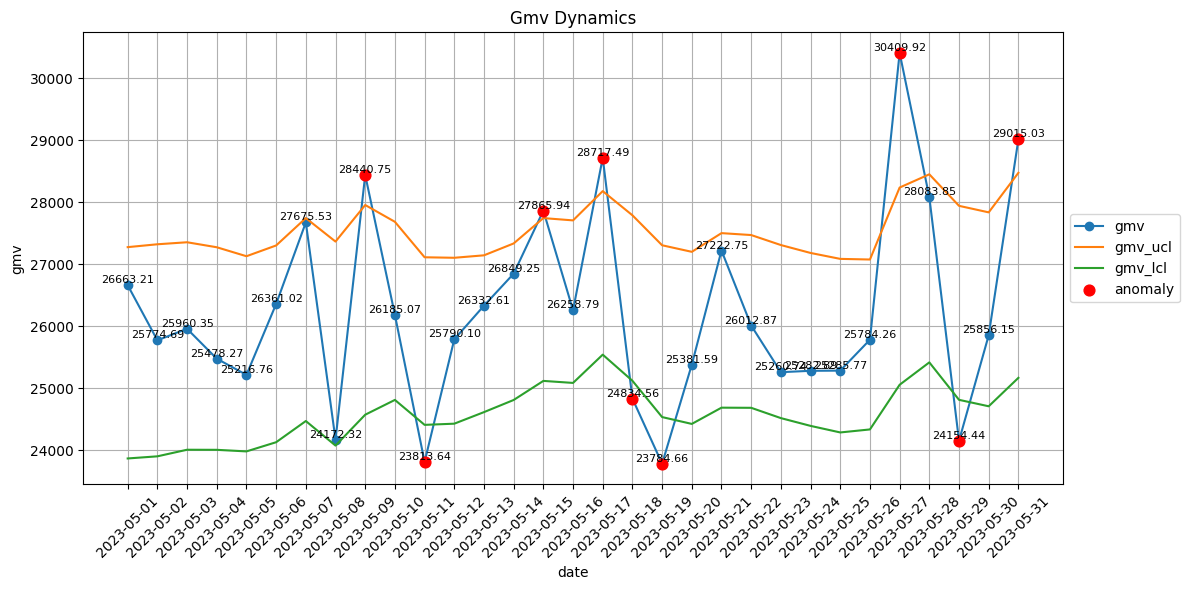

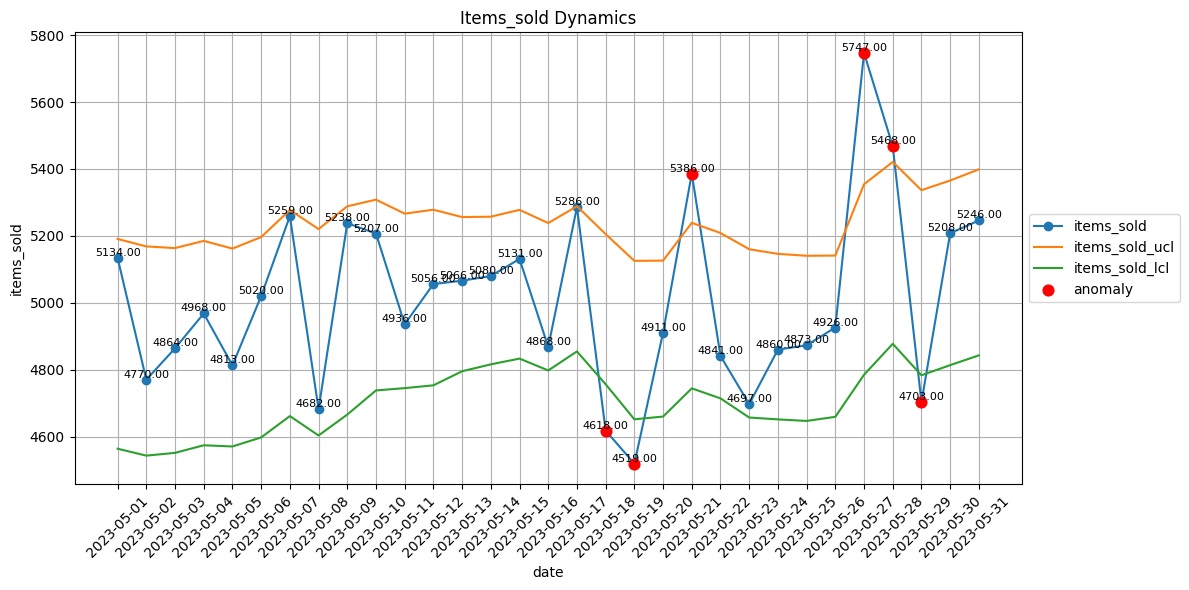

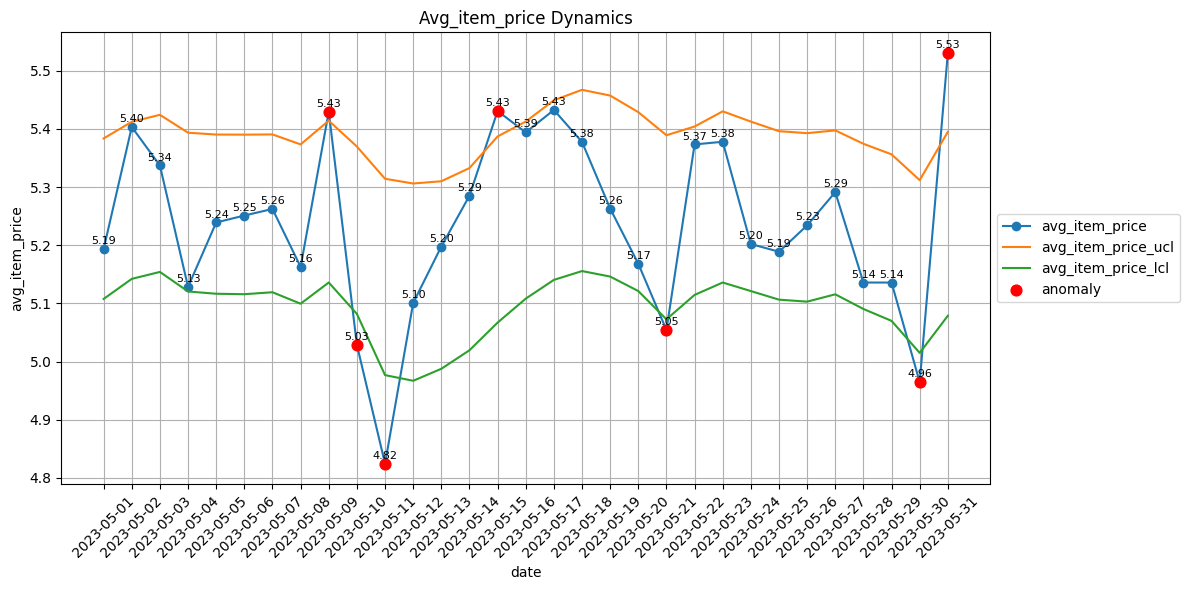

In [ ]:
# Применим EWMA ко всем метрикам
metrics = ['gmv', 'items_sold', 'avg_item_price']

for m in metrics:
    df = get_ewma_control(df, m, lambda_=0.2, L=3, window=28)

# Возьмем данные за май
df_may = df[(df['date'] >= pd.Timestamp(2023, 5, 1)) & (df['date'] < pd.Timestamp(2023, 6, 1))].copy()

# Визуализируем каждую метрику
for m in metrics:
    get_3sigma_vis(df_may, 'date', m)

In [ ]:
# Подсчет количества аномалий по каждой метрике
anomaly_summary_ewma = {m: int(df_may[f'is_anomaly_{m}'].sum()) for m in metrics}
anomaly_total_ewma = sum(anomaly_summary_ewma.values())

# выводим
print('Количество аномалий по каждой метрике (EWMA):')
for k, v in anomaly_summary_ewma.items():
    print(f'{k}: {v}')

Количество аномалий по каждой метрике (EWMA):
gmv: 9
items_sold: 6
avg_item_price: 7


**Задание**: введите сглаженное значение метрики avg_item_price, являющееся аномальным по методу EWMA. Ответ округлите до сотых.

In [ ]:
# найдём аномальное сглаженное значение для avg_item_price по EWMA
anomaly_value = (
    df_may.loc[df_may['is_anomaly_avg_item_price'], 'avg_item_price_ewma']
    .round(2)
    .iloc[0]
)

# выводим
print(df_may.loc[df_may['is_anomaly_avg_item_price'], 'avg_item_price_ewma'].round(2).tolist())
print(anomaly_value)


[5.28, 5.23, 5.15, 5.23, 5.23, 5.16, 5.24]
5.28


Для онлайн-мониторинга мне больше всего понравился EWMA, потому что он быстро реагирует на небольшие изменения тренда и при этом сглаживает шум.
Для ретроспективного анализа удобнее STL + ESD, так как позволяет отделить регулярные сезонные колебания и выявить редкие, нетипичные отклонения на остатках.